In [282]:
import ezdxf 
import sys
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import numpy as np
from scipy import spatial

In [283]:
try:
    doc = ezdxf.readfile("2horse.dxf")
except IOError:
    print(f"Not a DXF file or a generic I/O error.")
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f"Invalid or corrupted DXF file.")
    sys.exit(2)


In [284]:
class Line:
    def __init__(self, 
                 start: list, 
                 end: list, 
                 id_num,
                 force_2d = True):
        
        self.id = id_num
        self.shape = "line"
        
        if force_2d == True:
            self.start = start[:2]
            self.end = end[:2]
        else:
            self.start = start
            self.end = end
        dy = self.end[1] - self.start[1]
        dx = self.end[0] - self.start[0]
        
        #calculate slope of line
        self.slope = np.angle(complex(dx,dy), True)
            
class Arc: 
    def __init__(self, 
                 center: list, 
                 radius, 
                 start_angle, 
                 end_angle, 
                 start_point: list, 
                 end_point: list,
                id_num):
        
        self.shape = "arc"
        
        self.center = center[:2]
        self.radius = radius
        self.start_angle = start_angle
        self.end_angle = end_angle
        self.start_point = start_point[:2]
        self.end_point = end_point[:2]
        
        self.id = id_num
        
        #calculate slope of end and start points
        
        
        

In [285]:
# helper function
def print_entity(e):
    print("LINE on layer: %s\n" % e.dxf.layer)
    print("start point: %s\n" % e.dxf.start)
    print("end point: %s\n" % e.dxf.end)
    
#create network
G = nx.Graph()

# iterate over all entities in modelspace
msp = doc.modelspace()

#saves the actual data. Lines and arcs only.
entities = {"lines": [], "arcs": []}

#iterate over objects
num = 0

round_precision = 1

for e in msp: 
    
    if e.dxftype() == "LINE":
        
        #round numbers
        start_point = tuple([round(pos, round_precision) for pos in e.dxf.start][:2])
        end_point = tuple([round(pos, round_precision) for pos in e.dxf.end][:2])
        
        #save points in tuple (hashable type)
        #add point and edge with position saved 
        #print(f"points: {start_point} {end_point}")
        G.add_node(start_point, pos = start_point)
        G.add_node(end_point, pos = end_point)
        G.add_edge(start_point, end_point)
        
        nx.set_edge_attributes(G, {(start_point, end_point): num}, "id")
        entities["lines"].append(Line(start_point, end_point, num))
        num += 1
        
    elif (e.dxftype() == "ARC"):
        #treat arcs the same as lines in the graph
        start_point = tuple([round(pos,round_precision) for pos in e.start_point][:2])
        end_point = tuple([round(pos, round_precision) for pos in e.end_point][:2])
        
        #print(f"points: {start_point} {end_point}")
        
        G.add_node(start_point, pos = start_point)
        G.add_node(end_point, pos = end_point)
        G.add_edge(start_point, end_point)
        nx.set_edge_attributes(G, {(start_point, end_point): num}, "id")
        
        entities["arcs"].append(Arc(list(e.dxf.center),
                                e.dxf.radius,
                                e.dxf.start_angle,
                                e.dxf.end_angle,
                                list(e.start_point),
                                list(e.end_point),
                                   num))
        num += 1
        
# entity query for all LINE entities in modelspace
#for e in msp.query("LINE"):
    

In [286]:
cycles = nx.cycle_basis(G)

    
nodes = list(G)
hull = spatial.ConvexHull(nodes)
outer = []
for index in hull.vertices:
    outer.append(nodes[index])

blacklist = outer[:2] + outer[-2:]

print(blacklist)

index = 0

drawcycle = []
invalids = []
for cycle in cycles:
    valid = True
    for point in cycle:
        #print(f"{point}")
        if point in blacklist:
            print(f"cycle {index} invalid")
            valid = False
            break

    if valid == True:
        print(f"cycle {index} valid")
        drawcycle.append(cycle)
    else:
        invalids.append(cycle)
    index += 1



[(12.5, 0.0), (65.0, 0.0), (0.0, 65.0), (0.0, 12.5)]
cycle 0 valid
cycle 1 valid
cycle 2 valid
cycle 3 valid
cycle 4 valid
cycle 5 valid
cycle 6 valid
cycle 7 valid
cycle 8 valid
cycle 9 valid
cycle 10 valid
cycle 11 valid
cycle 12 valid
cycle 13 invalid
cycle 14 valid
cycle 15 invalid
cycle 16 valid
cycle 17 invalid


In [ ]:
#calculate center of each closed area

#S = [(x1 + x2 +...), (y1 + y2 +...)] / n

In [ ]:
plt.figure(figsize=(16,12), dpi=160)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_size=10)
#nx.draw_networkx_labels(G, pos, font_size=7)

In [ ]:
#compares angles
def sharp_edge_detection(edge1, edge2, bias = 5):
    pass
    

In [288]:
len(drawcycle)

15

In [289]:
k = nx.Graph()
nx.add_cycle(k, [0, 1, 2, 3])
nx.add_cycle(k, [0, 3, 4, 5])
print(nx.cycle_basis(k, 0))

[[3, 4, 5, 0], [1, 2, 3, 0]]


/tmp/ipykernel_6113/1353793274.py:9: MatplotlibDeprecationWarning: Passing argument *p* of unexpected type Line2D to add_patch which only accepts <class 'matplotlib.patches.Patch'> is deprecated since 3.5 and will become an error two minor releases later.
  plt.gca().add_patch(line_obj)


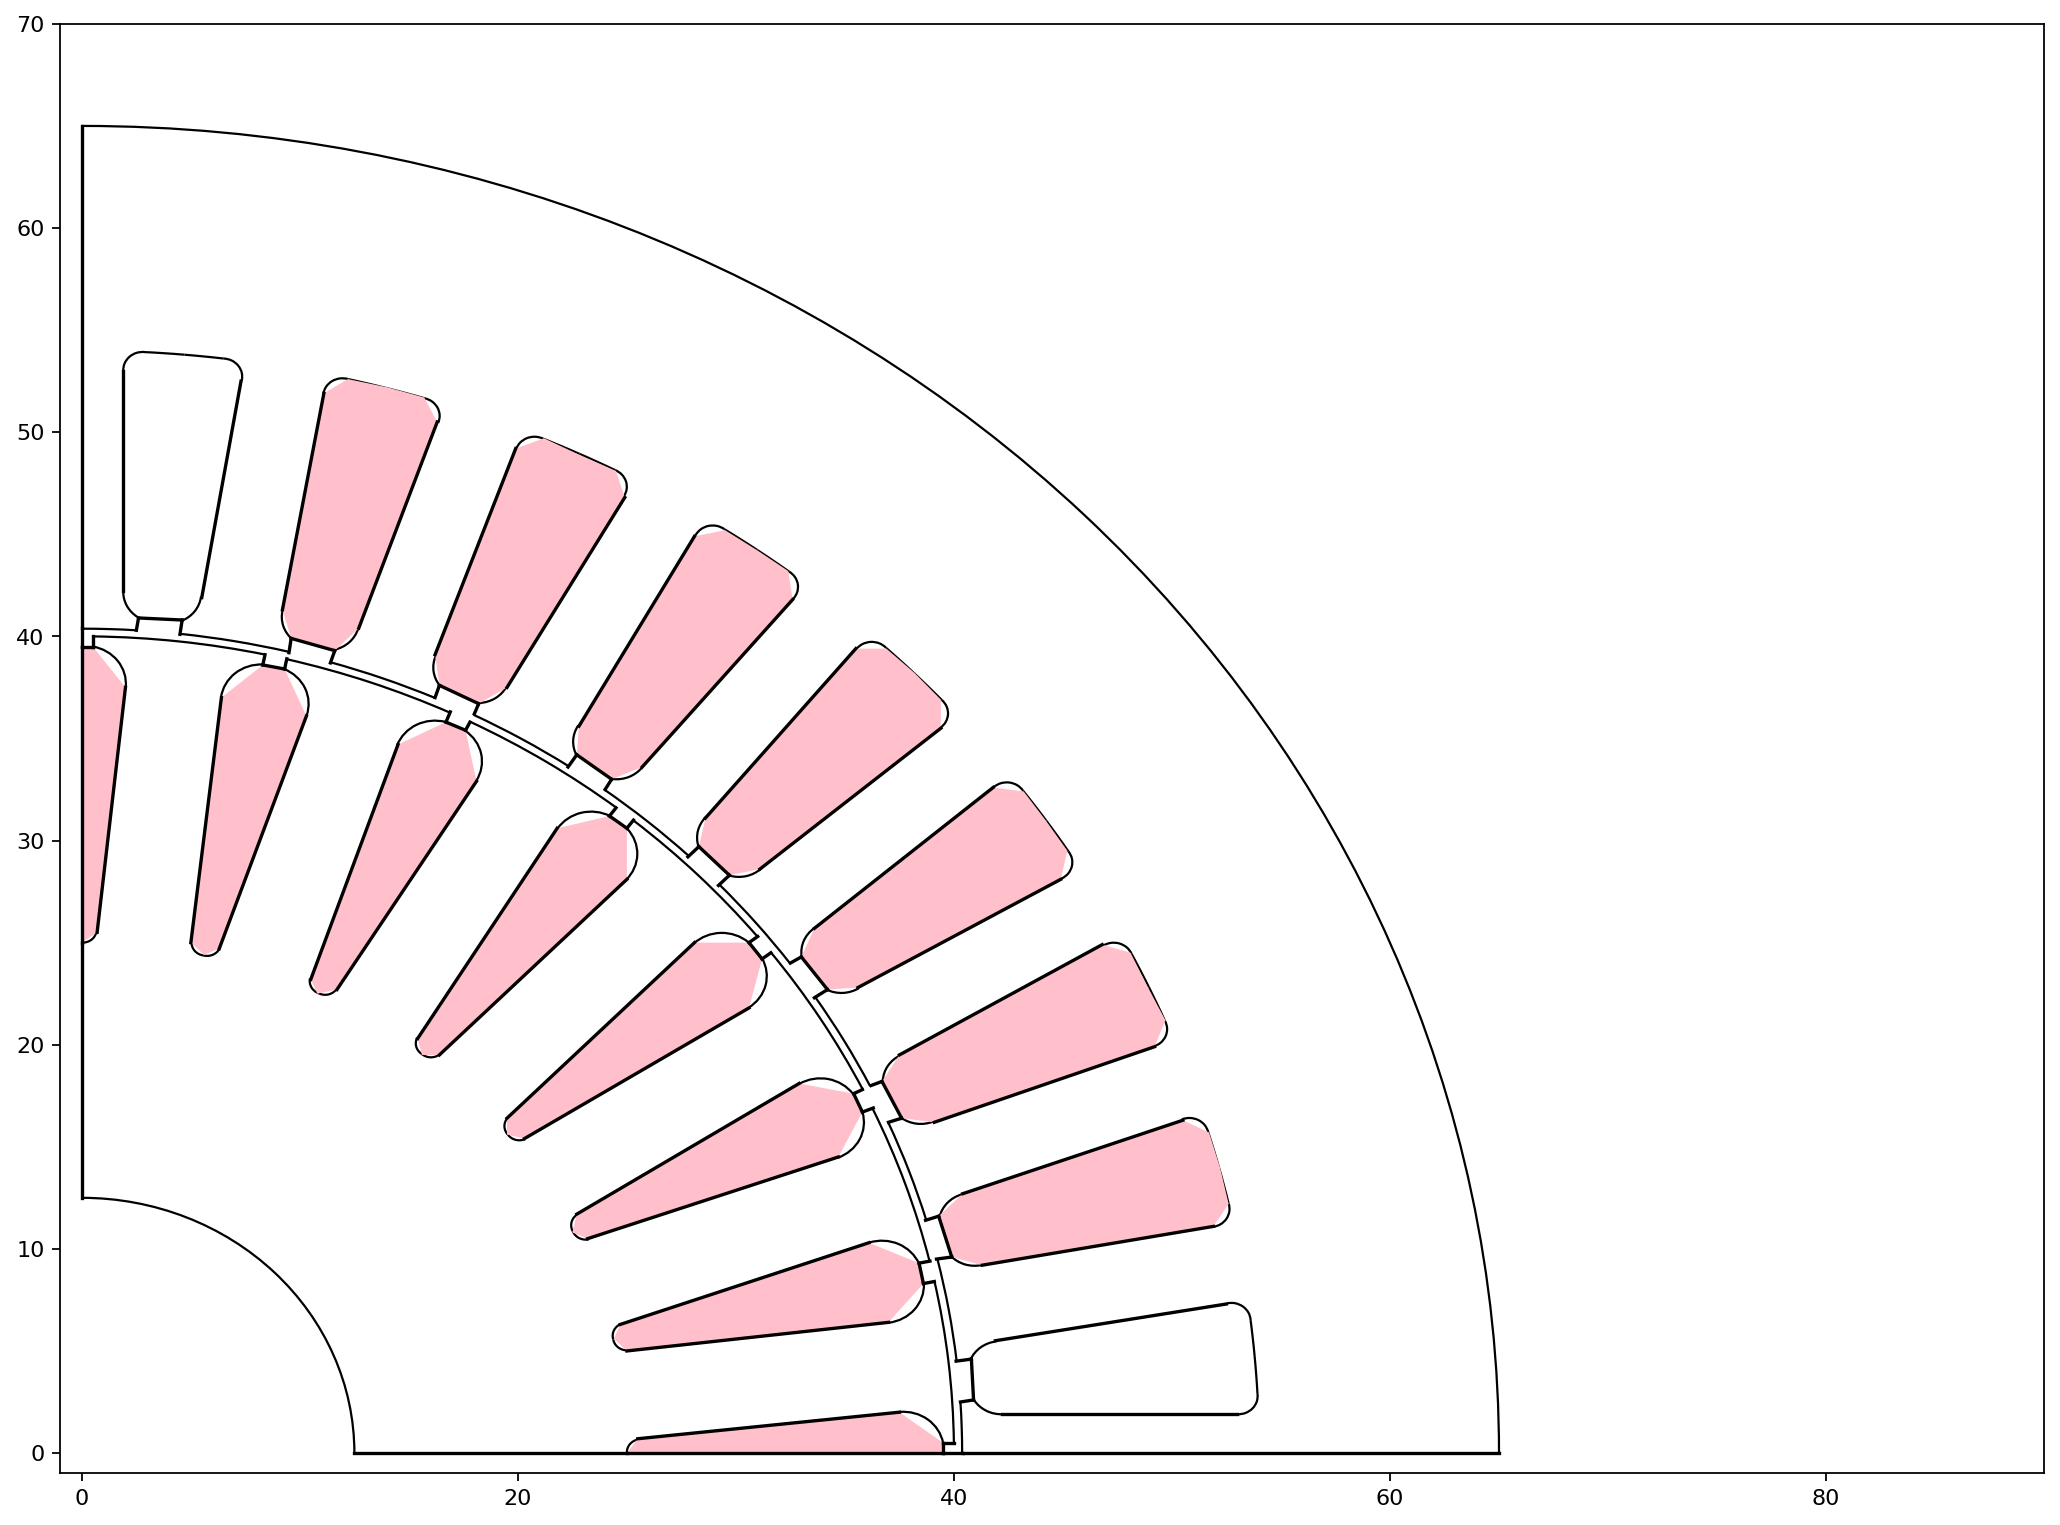

In [292]:

plt.figure(figsize=[16,12], dpi=160)
plt.ylim(0,70)
plt.xlim(0,70)

linecolor = "black"

for line in entities["lines"]:
    line_obj = plt.Line2D((line.start[0], line.end[0]), (line.start[1], line.end[1]), color=linecolor)
    plt.gca().add_patch(line_obj)
    
for arc in entities["arcs"]:
    arc_obj = patch.Arc(arc.center, arc.radius*2, arc.radius*2, 
                        theta1 = arc.start_angle, theta2 = arc.end_angle, edgecolor=linecolor)
    plt.gca().add_patch(arc_obj)

for poly in drawcycle:
    plt.fill([point[0] for point in poly], [point[1] for point in poly], facecolor="pink")

plt.axis([-1,90,-1,70])
plt.show()

In [291]:
len(invalids)

3